# Assignment 2
***
# Data Preparation
***
## Data Collection
***

In [1]:
import pandas as pd
import numpy as np

# Load RawData
rawData = pd.read_csv("../Data/Almond.csv")

***
## Data Exploration and Vizualization
***

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplot(column, data):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

print(rawData.info())

stats = rawData.describe()
print(stats)
missing_values_count = rawData.isnull().sum()

print("Missing values per feature:")
print(missing_values_count)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2803 entries, 0 to 2802
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        2803 non-null   int64  
 1   Length (major axis)       1946 non-null   float64
 2   Width (minor axis)        1861 non-null   float64
 3   Thickness (depth)         1799 non-null   float64
 4   Area                      2803 non-null   float64
 5   Perimeter                 2803 non-null   float64
 6   Roundness                 1946 non-null   float64
 7   Solidity                  2803 non-null   float64
 8   Compactness               2803 non-null   float64
 9   Aspect Ratio              1004 non-null   float64
 10  Eccentricity              1004 non-null   float64
 11  Extent                    2803 non-null   float64
 12  Convex hull(convex area)  2803 non-null   float64
 13  Type                      2803 non-null   object 
dtypes: float

In [3]:
correlation_matrix = rawData.drop(['Id', 'Type'], axis=1).corr()
print(correlation_matrix)

                          Length (major axis)  Width (minor axis)  \
Length (major axis)                  1.000000            0.837034   
Width (minor axis)                   0.837034            1.000000   
Thickness (depth)                    0.457854            0.594621   
Area                                 0.759006            0.474224   
Perimeter                            0.809442            0.445872   
Roundness                           -0.324040            0.028531   
Solidity                            -0.184822           -0.030441   
Compactness                          0.253359            0.095097   
Aspect Ratio                         0.500352           -0.044345   
Eccentricity                         0.490871           -0.034087   
Extent                              -0.007200           -0.033799   
Convex hull(convex area)             0.783393            0.478885   

                          Thickness (depth)      Area  Perimeter  Roundness  \
Length (major axis)    

***
## Imputation
***

In [4]:
# Import Sklearn libraries
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Retrieve Length, Width and Thickness for imputation
# Aswell as Area
# rawData_no_outliers.reset_index(drop=True, inplace=True)
p_LWTA = rawData[['Length (major axis)','Width (minor axis)','Thickness (depth)','Area']].copy()
# Set Area to NaN where length is NaN
p_LWTA['Area'] = np.where(p_LWTA['Length (major axis)'].notna(),
                          p_LWTA['Area'],
                          np.nan)

# Use iterative imputation using sklearn
imputer = IterativeImputer(max_iter=10, random_state=0)
d_LWTA_imputed = pd.DataFrame(imputer.fit_transform(p_LWTA), columns=p_LWTA.columns)

# Calculate Roundness using the imputed Area when there is length
d_LWTA_imputed['Roundness'] = 4 * d_LWTA_imputed['Area'] / (np.pi * d_LWTA_imputed['Length (major axis)']**2)

# Remove irrelavent features
p_proc = rawData.drop(columns=['Id']).copy()
p_proc[['Length (major axis)','Width (minor axis)','Thickness (depth)','Roundness']] = d_LWTA_imputed[['Length (major axis)','Width (minor axis)','Thickness (depth)','Roundness']]
p_proc['Aspect Ratio'] = p_proc['Length (major axis)']/p_proc['Width (minor axis)']
p_proc['Eccentricity'] = (1 - (p_proc['Width (minor axis)']/p_proc['Length (major axis)'])**2) ** 0.5

***
## Handling Potential Bias
***

In [5]:
from imblearn.under_sampling import RandomUnderSampler

In [6]:
X = p_proc[['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)', 'Area', 'Perimeter', 'Roundness', 'Solidity', 'Compactness', 'Aspect Ratio', 'Eccentricity', 'Extent', 'Convex hull(convex area)']]
Y = p_proc['Type']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, Y)

X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='Type')

print(X_resampled.shape)
print(y_resampled.shape)

(2781, 12)
(2781,)


***
## Data Split
***

In [7]:
# Import libraries for NN
# Pretty sure this shit is just magic
import torch
from sklearn.preprocessing import LabelEncoder

X_resampled.reset_index(drop=True, inplace=True)
y_resampled.reset_index(drop=True, inplace=True)

# Label encoding (Not Really?)
label_encoder = LabelEncoder()

# X,Y -> X_tensor,Y_tensor
X_tensor = torch.tensor(X_resampled.values, dtype=torch.float32)
y_tensor = torch.tensor(label_encoder.fit_transform(y_resampled), dtype=torch.long)

# Splitting Dataset into training, validation, and testing sets
# Train + (Val | Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, 
    y_tensor, 
    test_size=0.3, 
    stratify=y_tensor, 
    random_state=21
)

# Val + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=1/3, 
    stratify=y_temp, 
    random_state=69
)

# Check the distribution of classes in each set
print("Training set class distribution:\n", pd.Series(y_train).value_counts(normalize=True))
print("Validation set class distribution:\n", pd.Series(y_val).value_counts(normalize=True))
print("Testing set class distribution:\n", pd.Series(y_test).value_counts(normalize=True))


# Apply training data transformation across all three sets for consistency
mean = X_train.mean(dim=0)
std = X_train.std(dim=0)

X_train_norm = (X_train - mean)/std
X_val_norm = (X_val - mean)/std
X_test_norm = (X_test - mean)/std



Training set class distribution:
 0    0.333505
2    0.333505
1    0.332991
Name: proportion, dtype: float64
Validation set class distribution:
 1    0.334532
0    0.332734
2    0.332734
Name: proportion, dtype: float64
Testing set class distribution:
 1    0.333333
2    0.333333
0    0.333333
Name: proportion, dtype: float64


In [8]:
mean = X_tensor.mean(dim=0)
std = X_tensor.std(dim=0)
X_full = (X_tensor - mean)/std

In [9]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as Func
import torch.nn.init as init

class FirstLayer(nn.Module):
    def __init__(self, output_size, activation='relu', init_method='he'):
        super(FirstLayer, self).__init__()
        self.fc = nn.Linear(12, output_size)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

        if init_method == 'he':
            init.kaiming_normal_(self.fc.weight, nonlinearity='relu')
        elif init_method == 'xavier':
            init.xavier_normal_(self.fc.weight)
        else:
            raise ValueError(f"Unsupported initialization method: {init_method}")

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

class OutputLayer(nn.Module):
    def __init__(self, input_size):
        super(OutputLayer, self).__init__()
        self.fc = nn.Linear(input_size, 3)

    def forward(self, x):
        x = self.fc(x)
        return x

class ReluLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(ReluLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.activation = nn.ReLU()
        init.kaiming_normal_(self.fc.weight, nonlinearity='relu')
        self.out_features = output_size

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

class LeakyReluLayer(nn.Module):
    def __init__(self, input_size, output_size, neg_slope=0.01):
        super(LeakyReluLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.activation = nn.LeakyReLU(negative_slope=neg_slope)
        init.kaiming_normal_(self.fc.weight, nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

class PReLULayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(PReLULayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.activation = nn.PReLU()
        init.kaiming_normal_(self.fc.weight, nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

class SigmoidLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(SigmoidLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.activation = nn.Sigmoid()
        init.xavier_normal_(self.fc.weight)

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

class SwishLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(SwishLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.partial_activation = nn.Sigmoid()
        init.xavier_normal_(self.fc.weight)

    def forward(self, x):
        x = self.fc(x)
        return x * self.partial_activationti(x)


In [10]:
class DynamicNN(nn.Module):
    def __init__(self, no_hidden_layers, first_layer_neurons, alpha):
        super(DynamicNN, self).__init__()
        self.in_layer = FirstLayer(output_size=first_layer_neurons)
        hidden_layers = []
        
        current_neurons = first_layer_neurons
        
        for i in range(no_hidden_layers):
            if i > 0:
                current_neurons = max(int(first_layer_neurons * (1 - alpha * i)), 3)
                hidden_layers.append(ReluLayer(input_size=hidden_layers[-1].out_features, output_size=current_neurons))
            else:
                hidden_layers.append(ReluLayer(input_size=first_layer_neurons, output_size=current_neurons))
        
        
        self.out = OutputLayer(input_size=current_neurons)

        self.model = nn.Sequential(*hidden_layers)

    def forward(self, x):
        x = self.in_layer(x)
        x = self.model(x)
        return self.out(x)
        
    def print_structure(self):
        print("Input Layer: ", self.in_layer)
        for i, layer in enumerate(self.model):
            print(f"Hidden Layer {i + 1}: {layer}")
        print("Output Layer: ", self.out)

In [11]:
class NeuralNetworkA(nn.Module):
    def __init__(self):
        super(NeuralNetworkA, self).__init__()
        self.l1 = FirstLayer(8)
        self.l2 = ReluLayer(8,4)
        self.l3 = OutputLayer(4)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x

In [12]:
class NeuralNetworkB(nn.Module):
    def __init__(self):
        super(NeuralNetworkB, self).__init__()
        self.l1 = FirstLayer(10)
        self.l2 = ReluLayer(10,10)
        self.l3 = ReluLayer(10,10)
        self.l4 = OutputLayer(10)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        return x

In [13]:
class NeuralNetworkC(nn.Module):
    def __init__(self):
        super(NeuralNetworkC, self).__init__()
        self.l1 = FirstLayer(8)
        self.l2 = SwishLayer(8,6)
        self.l3 = OutputLayer(6)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x

***
## Helpers
***

In [14]:
from enum import Enum

class Optimizer(Enum):
    ADAM = 0        # Adam
    RPROP = 1       # Resilient Backpropagation
    SGD = 2         # Schocastic Gradient Decent

class Criterion(Enum):
    CEL = 0         # CrossEntropyLoss
    BCEWLL = 1      # BCEWithLogitsLoss

class Model(Enum):
    A = 0
    B = 1
    C = 2
    
def optimizerSelect(opt: Optimizer):
    if opt == Optimizer.ADAM:
        return optim.Adam
    elif opt == Optimizer.RPROP:
        return optim.Rprop
    else:
        return optim.SGD

def criterionSelect(opt: Criterion):
    if opt == Criterion.CEL:
        return nn.CrossEntropyLoss()
    elif opt == Criterion.BCEWLL:
        return nn.BCEWithLogitsLoss()

def modelSelect(opt: Model):
    if opt == Model.A:
        return NeuralNetworkA()
    elif opt == Model.B:
        return NeuralNetworkB()
    elif opt == Model.C: 
        return NeuralNetworkC()

def convert_tensor(X,Y,batch,shuffle):
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X, Y), batch_size=batch, shuffle=shuffle)

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def calculate_nh_1(N, M):
    """
    Calculate the number of hidden neurons using the formula:
    Nh = (N + M) / 2
    """
    return (N + M) / 2

def calculate_nh_2(T, N, M):
    """
    Calculate the number of hidden neurons using the formula:
    2Nh = T / (5 * (N + M))
    """
    return T / (5 * (N + M))

def calculate_nh_3(T, N):
    """
    Calculate the number of hidden neurons using the formula:
    Nh = sqrt(T / (N * log(T)))
    """
    return np.sqrt(T / (N * np.log(T)))

def calculate_nh_4(N, M):
    """
    Calculate the number of hidden neurons using the formula:
    Nh = sqrt(N * M)
    """
    return np.sqrt(N * M)

In [15]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        
    
    accuracy = correct_predictions / total_samples
    return total_loss / len(val_loader), accuracy

In [16]:
def detailed_train_model(model, num_epochs, train_loader, criterion, optimizer):
    model.train()
    loss_per_batch = []
    loss_per_epoch = []
    
    grad_list = {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            grad_list[name] = []
    
    average_loss = 0.0
    total_loss = 0.0
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_per_batch.append(loss.item())
            epoch_loss += loss.item()
            
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                grad_list[name].append(param.grad.abs().mean().item())
            
        average_loss = epoch_loss / len(train_loader)
        loss_per_epoch.append(average_loss)
        total_loss += average_loss
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.4f}")

    average_loss = total_loss / num_epochs
    for layer_name, gradients in grad_list.items():
        plt.plot(gradients, label=layer_name)
    plt.xlabel("Epochs")
    plt.ylabel("Average Gradient Magnitude")
    plt.legend()
    plt.title("Gradient Flow Over Time")
    plt.show()
    return loss_per_batch, loss_per_epoch, average_loss

def plot_loss(batch_loss_values, epoch_loss_values, num_epochs):
    plt.figure(figsize=(12, 6))

    plt.plot(batch_loss_values, label='Batch Loss', color='blue', linestyle='-', linewidth=2)

    epochs = list(range(1, num_epochs + 1))
    plt.plot([epoch * len(batch_loss_values) // num_epochs - 1 for epoch in epochs], epoch_loss_values, 
             label='Average Epoch Loss', color='orange', linestyle='--', marker='o')

    plt.title('Loss over Batches and Average Loss per Epoch')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if p.requires_grad and "bias" not in n:
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().item())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient")
    plt.title("Gradient flow")
    plt.grid(True)

def compute_grad_norm(named_parameters):
    grad_norms = []
    for name, param in named_parameters:
        if param.requires_grad and param.grad is not None:
            grad_norm = param.grad.norm(2).item()
            grad_norms.append((name, grad_norm))
    return grad_norms

***
## K-Fold cross Validation Defintions
***

In [17]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import torch
import numpy as np

def k_fold_cross_val(
    model_opt: str, 
    criterion_opt: str, 
    optimizer_opt: str, 
    X_tensor, 
    Y_tensor, 
    k: int, 
    num_epochs: int,
    learning_rate: float,
    batch_size: int,
    verbose: bool = True
):
    dataset = TensorDataset(X_tensor, Y_tensor)
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=21)
    
    fold_results = {
        'accuracy': [],
        'validation_loss': [],
        'training_loss': [],
        'training_accuracy': [],
        'confusion_matrices': [],
        'classification_reports': []
    }
    
    for fold, (train_index, val_index) in enumerate(skf.split(X_tensor, Y_tensor)):
        
        train_loader = DataLoader(dataset=dataset, sampler=torch.utils.data.SubsetRandomSampler(train_index), batch_size=batch_size)
        val_loader = DataLoader(dataset=dataset, sampler=torch.utils.data.SubsetRandomSampler(val_index), batch_size=batch_size)
        
        model = modelSelect(opt=model_opt)
        criterion = criterionSelect(opt=criterion_opt)
        optimizer = optimizerSelect(opt=optimizer_opt)(model.parameters(), lr=learning_rate)
        
        fold_training_loss = []
        fold_training_accuracy = []

        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            avg_loss = epoch_loss / len(train_loader)
            avg_accuracy = correct / total
            
            fold_training_loss.append(avg_loss)
            fold_training_accuracy.append(avg_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
    
        accuracy = correct / total
        fold_results['accuracy'].append(accuracy)
        fold_results['training_loss'].append(sum(fold_training_loss) / len(fold_training_loss))
        fold_results['training_accuracy'].append(sum(fold_training_accuracy) / len(fold_training_accuracy))
        fold_results['validation_loss'].append(val_loss / len(val_loader))
        fold_results['confusion_matrices'].append(confusion_matrix(all_labels, all_predictions))
        fold_results['classification_reports'].append(classification_report(all_labels, all_predictions, output_dict=True))
        
        if verbose:
            print(f"Fold {fold + 1}:")
            print(f"  Training Loss: {sum(fold_training_loss) / len(fold_training_loss):.4f}")
            print(f"  Training Accuracy: {sum(fold_training_accuracy) / len(fold_training_accuracy):.4f}")
            print(f"  Validation Accuracy: {accuracy:.4f}")
            print(f"  Validation Loss: {val_loss / len(val_loader):.4f}")
    
    # Calculate mean and standard deviation for each metric across all folds
    fold_summary = {
        'mean_accuracy': np.mean(fold_results['accuracy']),
        'std_accuracy': np.std(fold_results['accuracy']),
        'mean_training_loss': np.mean(fold_results['training_loss']),
        'std_training_loss': np.std(fold_results['training_loss']),
        'mean_training_accuracy': np.mean(fold_results['training_accuracy']),
        'std_training_accuracy': np.std(fold_results['training_accuracy']),
        'mean_validation_loss': np.mean(fold_results['validation_loss']),
        'std_validation_loss': np.std(fold_results['validation_loss'])
    }
    
    if verbose:
        print("\nCross-validation results:")
        print(f"Mean Training Loss: {fold_summary['mean_training_loss']:.4f} ± {fold_summary['std_training_loss']:.4f}")
        print(f"Mean Training Accuracy: {fold_summary['mean_training_accuracy']:.4f} ± {fold_summary['std_training_accuracy']:.4f}")
        print(f"Mean Validation Loss: {fold_summary['mean_validation_loss']:.4f} ± {fold_summary['std_validation_loss']:.4f}")
        print(f"Mean Validation Accuracy: {fold_summary['mean_accuracy']:.4f} ± {fold_summary['std_accuracy']:.4f}")

    return fold_results, fold_summary


In [18]:
from tabulate import tabulate

def display_k_fold_results(fold_results, fold_summary):
    
    # Create the fold results table
    table_data = []
    for fold in range(len(fold_results['accuracy'])):
        table_data.append([
            fold + 1,
            fold_results['training_loss'][fold],
            fold_results['training_accuracy'][fold],
            fold_results['validation_loss'][fold],
            fold_results['accuracy'][fold]
        ])

    headers = ["Fold", "Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy"]

    print("K-Fold Cross-Validation Results:")
    print(tabulate(table_data, headers=headers, tablefmt='grid'))

    # Display summary statistics
    print("\nSummary of Cross-Validation Results:")
    summary_data = [
        ["Mean Training Loss", f"{fold_summary['mean_training_loss']:.4f} ± {fold_summary['std_training_loss']:.4f}"],
        ["Mean Training Accuracy", f"{fold_summary['mean_training_accuracy']:.4f} ± {fold_summary['std_training_accuracy']:.4f}"],
        ["Mean Validation Loss", f"{fold_summary['mean_validation_loss']:.4f} ± {fold_summary['std_validation_loss']:.4f}"],
        ["Mean Validation Accuracy", f"{fold_summary['mean_accuracy']:.4f} ± {fold_summary['std_accuracy']:.4f}"]
    ]

    print(tabulate(summary_data, headers=["Metric", "Value"], tablefmt='grid'))

    # Create and display averaged classification report
    avg_precision = np.mean([report['weighted avg']['precision'] for report in fold_results['classification_reports']])
    avg_recall = np.mean([report['weighted avg']['recall'] for report in fold_results['classification_reports']])
    avg_f1 = np.mean([report['weighted avg']['f1-score'] for report in fold_results['classification_reports']])
    avg_support = np.mean([report['weighted avg']['support'] for report in fold_results['classification_reports']])
    
    avg_classification_data = [
        ["Averaged Precision", avg_precision],
        ["Averaged Recall", avg_recall],
        ["Averaged F1-score", avg_f1],
        ["Averaged Support", avg_support]
    ]

    print("\nAveraged Classification Metrics:")
    print(tabulate(avg_classification_data, headers=["Metric", "Value"], tablefmt='grid'))

    for fold, confusion_matrix in enumerate(fold_results['confusion_matrices'], start=1):
        print(f"\nConfusion Matrix for Fold {fold}:\n{confusion_matrix}")

    for fold, report in enumerate(fold_results['classification_reports'], start=1):
        print(f"\nClassification Report for Fold {fold}:\n{tabularize_classification_report(report)}")

def tabularize_classification_report(report):
    rows = []
    
    for label, metrics in report.items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            row = [
                label,
                metrics['precision'],
                metrics['recall'],
                metrics['f1-score'],
                metrics['support']
            ]
            rows.append(row)
    
    averages = report['macro avg']
    weighted_averages = report['weighted avg']
    
    rows.append([
        'Macro Avg',
        averages['precision'],
        averages['recall'],
        averages['f1-score'],
        averages['support']
    ])

    rows.append([
        'Weighted Avg',
        weighted_averages['precision'],
        weighted_averages['recall'],
        weighted_averages['f1-score'],
        weighted_averages['support']
    ])
    
    headers = ['Class', 'Precision', 'Recall', 'F1-score', 'Support']
    
    return tabulate(rows, headers=headers, tablefmt='pretty')


***
## Grid Search with K fold validation
***

In [19]:
def grid_search(
    model_opt: Model, 
    criterion_opt: Criterion, 
    optimizer_opt: Optimizer, 
    X_tensor, 
    Y_tensor, 
    k: int, 
    num_epochs_array: list[int], 
    learning_rate_array: list[int],
    batch_size: int
):
    grid_results = []
    
    for lr in learning_rate_array:
        for num_epochs in num_epochs_array:
            print(f"Training with Learning Rate: {lr}, Epochs: {num_epochs}")
            fold_results, fold_summary = k_fold_cross_val(
                model_opt=model_opt,
                criterion_opt=criterion_opt,
                optimizer_opt=optimizer_opt,
                X_tensor=X_tensor,
                Y_tensor=Y_tensor,
                k=k,
                num_epochs=num_epochs,
                learning_rate=lr,
                batch_size=batch_size,
                verbose=False
            )
            
            avg_accuracy = np.mean(fold_results['accuracy'])
            avg_training_loss = np.mean(fold_results['training_loss'])
            avg_training_accuracy = np.mean(fold_results['training_accuracy'])
            avg_validation_loss = np.mean(fold_results['validation_loss'])

            grid_results.append({
                'learning_rate': lr,
                'num_epochs': num_epochs,
                'avg_accuracy': avg_accuracy,
                'avg_training_loss': avg_training_loss,
                'avg_training_accuracy': avg_training_accuracy,
                'avg_validation_loss': avg_validation_loss
            })
    
    results_df = pd.DataFrame(grid_results)
    return results_df

In [20]:
def plot_grid_search_results(results_df, save: bool = False, file_path: str = "./images/grid_search.png"):
    training_accuracy_pivot = results_df.pivot(index="num_epochs", columns="learning_rate", values="avg_training_accuracy")
    accuracy_pivot = results_df.pivot(index="num_epochs", columns="learning_rate", values="avg_accuracy")

    training_loss_pivot = results_df.pivot(index="num_epochs", columns="learning_rate", values="avg_training_loss")
    loss_pivot = results_df.pivot(index="num_epochs", columns="learning_rate", values="avg_validation_loss")
    
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    sns.heatmap(training_accuracy_pivot, annot=True, fmt=".3f", cmap="YlGnBu", ax=axs[0, 0])
    axs[0,0].set_title("Average Training Accuracy")
    axs[0,0].set_xlabel("Learning Rate")
    axs[0,0].set_ylabel("Number of Epochs")

    sns.heatmap(training_loss_pivot, annot=True, fmt=".3f", cmap="YlOrRd", ax=axs[0, 1])
    axs[0,1].set_title("Average Training Loss")
    axs[0,1].set_xlabel("Learning Rate")
    axs[0,1].set_ylabel("Number of Epochs")
    
    sns.heatmap(accuracy_pivot, annot=True, fmt=".3f", cmap="YlGnBu", ax=axs[1, 0])
    axs[1,0].set_title("Average Validation Accuracy")
    axs[1,0].set_xlabel("Learning Rate")
    axs[1,0].set_ylabel("Number of Epochs")

    sns.heatmap(loss_pivot, annot=True, fmt=".3f", cmap="YlOrRd", ax=axs[1, 1])
    axs[1,1].set_title("Average Validation Loss")
    axs[1,1].set_xlabel("Learning Rate")
    axs[1,1].set_ylabel("Number of Epochs")

    plt.tight_layout()
    if save:
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()

In [67]:
learning_rates = [0.001, 0.005, 0.01, 0.05]
num_epochs = [50, 100, 150, 200, 250]
results = grid_search(
    model_opt=Model.B,
    criterion_opt=Criterion.CEL,
    optimizer_opt=Optimizer.RPROP,
    X_tensor=X_train_norm,
    Y_tensor=y_train,
    k=5,
    batch_size=32,
    learning_rate_array=learning_rates,
    num_epochs_array=num_epochs
)
# Ignore issues regarding zero division, they are for metrics I am not using

Training with Learning Rate: 0.001, Epochs: 50
Training with Learning Rate: 0.001, Epochs: 100
Training with Learning Rate: 0.001, Epochs: 150
Training with Learning Rate: 0.001, Epochs: 200
Training with Learning Rate: 0.001, Epochs: 250
Training with Learning Rate: 0.005, Epochs: 50
Training with Learning Rate: 0.005, Epochs: 100
Training with Learning Rate: 0.005, Epochs: 150
Training with Learning Rate: 0.005, Epochs: 200
Training with Learning Rate: 0.005, Epochs: 250
Training with Learning Rate: 0.01, Epochs: 50
Training with Learning Rate: 0.01, Epochs: 100
Training with Learning Rate: 0.01, Epochs: 150
Training with Learning Rate: 0.01, Epochs: 200
Training with Learning Rate: 0.01, Epochs: 250
Training with Learning Rate: 0.05, Epochs: 50
Training with Learning Rate: 0.05, Epochs: 100
Training with Learning Rate: 0.05, Epochs: 150
Training with Learning Rate: 0.05, Epochs: 200
Training with Learning Rate: 0.05, Epochs: 250


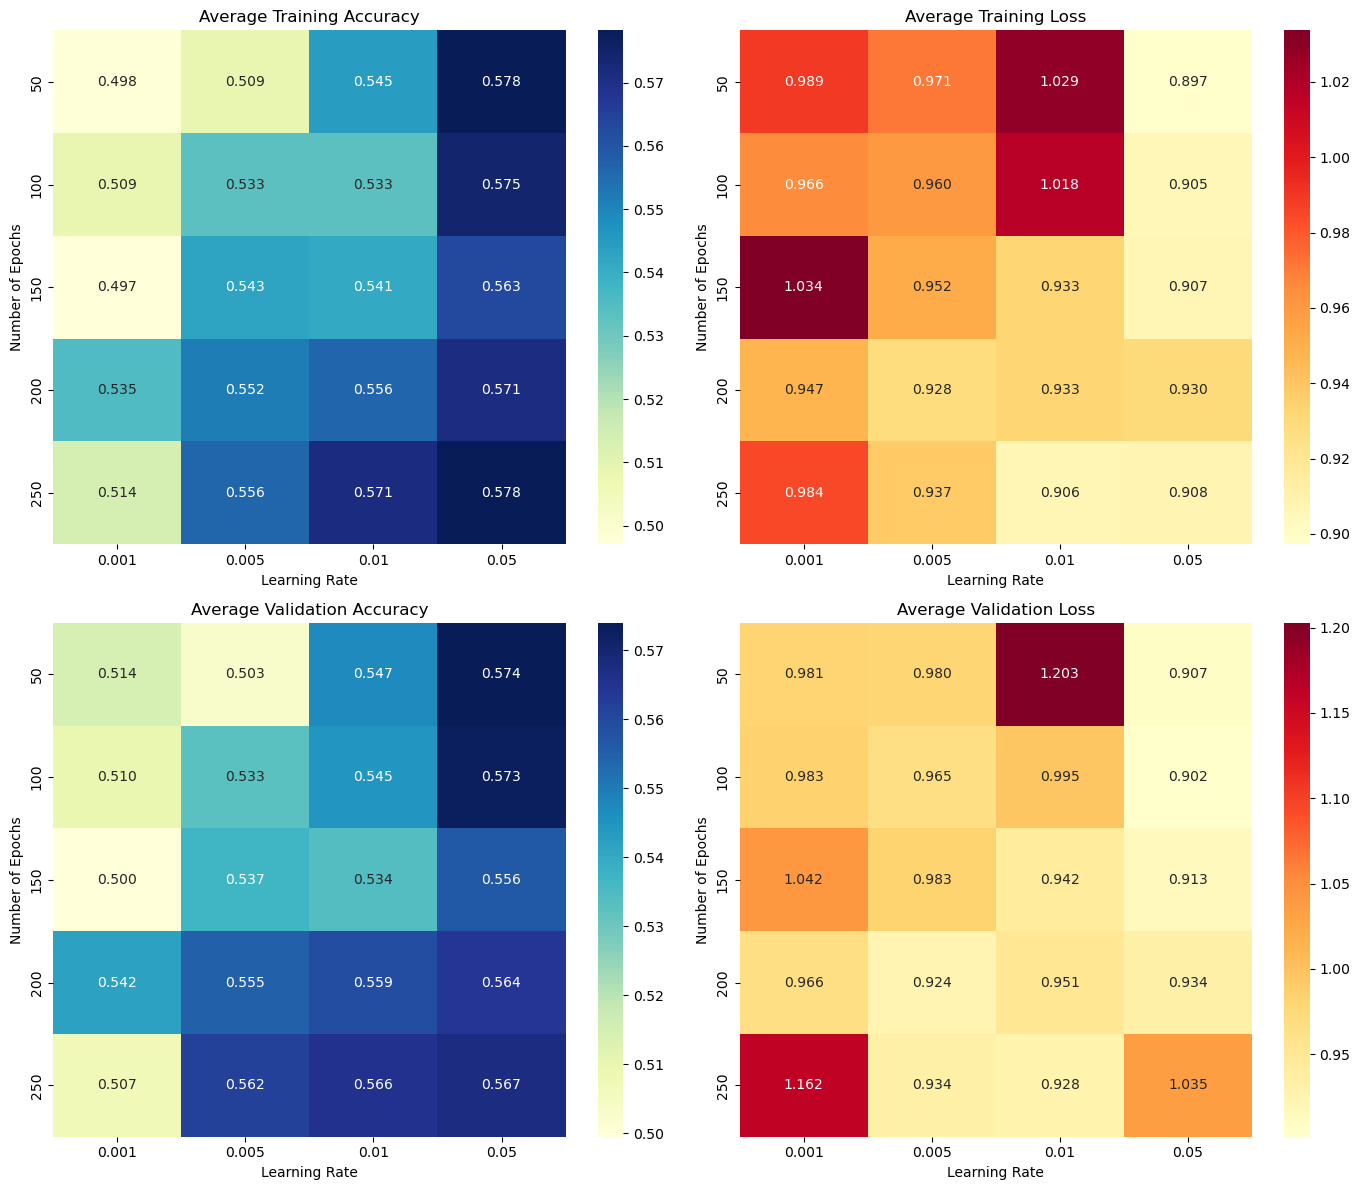

In [70]:
plot_grid_search_results(results, save=True, file_path="./images/GridSearch_RPROP.png")

***
## Training Algorithms
***
### Shared Hyperparameters
***

In [21]:
learning_rate  =0.01
num_epochs = 100
batch_size = 32
criterion_opt = Criterion.CEL
random_seed = 21
k =5

***
## Adam
***

In [32]:
optimizer_opt = Optimizer.ADAM

In [56]:
fold_results, fold_summary = k_fold_cross_val(
                model_opt=Model.B,
                criterion_opt=criterion_opt,
                optimizer_opt=optimizer_opt,
                X_tensor=X_train_norm,
                Y_tensor=y_train,
                k=5,
                num_epochs=250,
                learning_rate=0.005,
                batch_size=batch_size,
                verbose=True
            )

Fold 1:
  Training Loss: 0.7555
  Training Accuracy: 0.6430
  Validation Accuracy: 0.6710
  Validation Loss: 0.7468
Fold 2:
  Training Loss: 0.8206
  Training Accuracy: 0.6049
  Validation Accuracy: 0.6432
  Validation Loss: 0.7725
Fold 3:
  Training Loss: 0.7919
  Training Accuracy: 0.6273
  Validation Accuracy: 0.7079
  Validation Loss: 0.6724
Fold 4:
  Training Loss: 0.8309
  Training Accuracy: 0.6065
  Validation Accuracy: 0.6647
  Validation Loss: 0.6984

Cross-validation results:
Mean Training Loss: 0.7998 ± 0.0293
Mean Training Accuracy: 0.6204 ± 0.0158
Mean Validation Loss: 0.7225 ± 0.0393
Mean Validation Accuracy: 0.6717 ± 0.0233


In [38]:
display_k_fold_results(fold_results=fold_results,fold_summary=fold_summary)

K-Fold Cross-Validation Results:
+--------+-----------------+---------------------+-------------------+-----------------------+
|   Fold |   Training Loss |   Training Accuracy |   Validation Loss |   Validation Accuracy |
+========+=================+=====================+===================+=======================+
|      1 |        0.565491 |            0.741427 |          0.654075 |              0.771795 |
+--------+-----------------+---------------------+-------------------+-----------------------+
|      2 |        0.570578 |            0.73745  |          0.610717 |              0.750643 |
+--------+-----------------+---------------------+-------------------+-----------------------+
|      3 |        0.584836 |            0.738516 |          0.877401 |              0.688946 |
+--------+-----------------+---------------------+-------------------+-----------------------+
|      4 |        0.582312 |            0.741644 |          0.713504 |              0.699229 |
+--------+-------

***
## RProp
***

In [39]:
optimizer_opt = Optimizer.RPROP

In [40]:
fold_results, fold_summary = k_fold_cross_val(
                model_opt=Model.B,
                criterion_opt=criterion_opt,
                optimizer_opt=optimizer_opt,
                X_tensor=X_train_norm,
                Y_tensor=y_train,
                k=k,
                num_epochs=num_epochs,
                learning_rate=learning_rate,
                batch_size=batch_size,
                verbose=True
            )

Fold 1:
  Training Loss: 0.9809
  Training Accuracy: 0.5595
  Validation Accuracy: 0.5769
  Validation Loss: 0.9687
Fold 2:
  Training Loss: 0.9281
  Training Accuracy: 0.5254
  Validation Accuracy: 0.5656
  Validation Loss: 0.9230
Fold 3:
  Training Loss: 0.9517
  Training Accuracy: 0.5584
  Validation Accuracy: 0.5501
  Validation Loss: 0.9533
Fold 4:
  Training Loss: 0.9527
  Training Accuracy: 0.5298
  Validation Accuracy: 0.5116
  Validation Loss: 0.9514
Fold 5:
  Training Loss: 0.9280
  Training Accuracy: 0.5722
  Validation Accuracy: 0.5424
  Validation Loss: 0.9516

Cross-validation results:
Mean Training Loss: 0.9483 ± 0.0195
Mean Training Accuracy: 0.5491 ± 0.0182
Mean Validation Loss: 0.9496 ± 0.0148
Mean Validation Accuracy: 0.5493 ± 0.0224


In [41]:
display_k_fold_results(fold_results=fold_results,fold_summary=fold_summary)

K-Fold Cross-Validation Results:
+--------+-----------------+---------------------+-------------------+-----------------------+
|   Fold |   Training Loss |   Training Accuracy |   Validation Loss |   Validation Accuracy |
+========+=================+=====================+===================+=======================+
|      1 |        0.980856 |            0.559479 |          0.968688 |              0.576923 |
+--------+-----------------+---------------------+-------------------+-----------------------+
|      2 |        0.928132 |            0.525401 |          0.92299  |              0.565553 |
+--------+-----------------+---------------------+-------------------+-----------------------+
|      3 |        0.951738 |            0.558446 |          0.95328  |              0.550129 |
+--------+-----------------+---------------------+-------------------+-----------------------+
|      4 |        0.952658 |            0.529775 |          0.95136  |              0.511568 |
+--------+-------

***
## SGD
***

In [42]:
optimizer_opt = Optimizer.SGD

In [44]:
fold_results, fold_summary = k_fold_cross_val(
                model_opt=Model.B,
                criterion_opt=criterion_opt,
                optimizer_opt=optimizer_opt,
                X_tensor=X_train_norm,
                Y_tensor=y_train,
                k=k,
                num_epochs=num_epochs,
                learning_rate=learning_rate,
                batch_size=batch_size,
                verbose=True
            )

Fold 1:
  Training Loss: 0.8824
  Training Accuracy: 0.5670
  Validation Accuracy: 0.6385
  Validation Loss: 0.7792
Fold 2:
  Training Loss: 0.8954
  Training Accuracy: 0.5691
  Validation Accuracy: 0.6221
  Validation Loss: 0.8086
Fold 3:
  Training Loss: 0.9039
  Training Accuracy: 0.5669
  Validation Accuracy: 0.6093
  Validation Loss: 0.8224
Fold 4:
  Training Loss: 0.8459
  Training Accuracy: 0.5910
  Validation Accuracy: 0.6118
  Validation Loss: 0.7886
Fold 5:
  Training Loss: 0.8142
  Training Accuracy: 0.6021
  Validation Accuracy: 0.6555
  Validation Loss: 0.7337

Cross-validation results:
Mean Training Loss: 0.8684 ± 0.0336
Mean Training Accuracy: 0.5792 ± 0.0146
Mean Validation Loss: 0.7865 ± 0.0304
Mean Validation Accuracy: 0.6274 ± 0.0174


In [45]:
display_k_fold_results(fold_results=fold_results,fold_summary=fold_summary)

K-Fold Cross-Validation Results:
+--------+-----------------+---------------------+-------------------+-----------------------+
|   Fold |   Training Loss |   Training Accuracy |   Validation Loss |   Validation Accuracy |
+========+=================+=====================+===================+=======================+
|      1 |        0.882433 |            0.566992 |          0.77924  |              0.638462 |
+--------+-----------------+---------------------+-------------------+-----------------------+
|      2 |        0.895423 |            0.569069 |          0.808566 |              0.622108 |
+--------+-----------------+---------------------+-------------------+-----------------------+
|      3 |        0.903936 |            0.566859 |          0.822446 |              0.609254 |
+--------+-----------------+---------------------+-------------------+-----------------------+
|      4 |        0.845866 |            0.590976 |          0.788613 |              0.611825 |
+--------+-------

***
## Hybrid
***
### THE WORK AROUND
Instead of trying to make mutiple optimizers work on the same set of model parameters, use multiple seperate models and calculate and share updates between them

In [22]:
def hybrid_train_model(model_opt, criterion_opt, train_loader, num_epochs, learning_rate):
    
    modelAdam = modelSelect(opt=model_opt)
    modelRProp = modelSelect(opt=model_opt)
    modelSGD = modelSelect(opt=model_opt)
    criterion = torch.nn.CrossEntropyLoss()
    optimizerAdam = optim.Adam(modelAdam.parameters(), lr=learning_rate)
    optimizerRProp = optim.Rprop(modelRProp.parameters(), lr=learning_rate)
    optimizerSGD = optim.SGD(modelSGD.parameters(), lr=learning_rate)

    loss_per_batch = []
    loss_per_epoch = []

    total_loss = 0.0
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            
            optimizerAdam.zero_grad()
            optimizerRProp.zero_grad()
            optimizerSGD.zero_grad()
            
            outputsAdam = modelAdam(inputs)
            outputsRProp = modelRProp(inputs)
            outputsSGD = modelSGD(inputs)
            
            lossAdam = criterion(outputsAdam, labels)
            lossRProp = criterion(outputsRProp, labels)
            lossSGD = criterion(outputsSGD, labels)
            
            lossAdam.backward()
            lossRProp.backward()
            lossSGD.backward()
            
            optimizerAdam.step()
            optimizerRProp.step()
            optimizerSGD.step()

            updatesAdam = []
            updatesRProp = []
            updatesSGD = []

            with torch.no_grad():
                for param_adam, param_rprop, param_sgd in zip(modelAdam.parameters(), modelRProp.parameters() , modelSGD.parameters()):
                    if param_sgd.grad is not None and param_rprop.grad is not None and param_adam.grad is not None:
                        # Adam update
                        adam_update = -optimizerAdam.param_groups[0]['lr'] * param_adam.grad
                        updatesAdam.append(adam_update)

                        # RProp update
                        rprop_update = -optimizerRProp.param_groups[0]['lr'] * param_rprop.grad
                        updatesRProp.append(rprop_update)
                        
                        # SGD update
                        sgd_update = -optimizerSGD.param_groups[0]['lr'] * param_sgd.grad
                        updatesSGD.append(sgd_update)

            averaged_updates = [(adam + rprop + sgd) / 3 for adam, rprop, sgd in zip(updatesAdam, updatesRProp, updatesSGD)]

            with torch.no_grad():
                for param, update in zip(modelAdam.parameters(), averaged_updates):
                    param.data += update
                for param, update in zip(modelRProp.parameters(), averaged_updates):
                    param.data += update
                for param, update in zip(modelSGD.parameters(), averaged_updates):
                    param.data += update 
                

            batch_avg_loss = (lossAdam.item() + lossRProp.item() + lossSGD.item())/3
            loss_per_batch.append(batch_avg_loss)
            epoch_loss += batch_avg_loss
            
        average_loss = epoch_loss / len(train_loader)
        loss_per_epoch.append(average_loss)
        total_loss += average_loss
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.4f}")

    average_loss = total_loss / num_epochs
    
    return loss_per_batch, loss_per_epoch, average_loss

In [23]:
loss_per_batch, loss_per_epoch, average_loss = hybrid_train_model(
    model_opt=Model.A,
    criterion_opt=Criterion.CEL,
    train_loader=convert_tensor(
        X=X_train_norm,
        Y=y_train,
        batch=32,
        shuffle=True
    ),
    num_epochs=200,
    learning_rate=0.01
)

Epoch [1/200], Average Loss: 1.0544
Epoch [2/200], Average Loss: 0.9878
Epoch [3/200], Average Loss: 0.9678
Epoch [4/200], Average Loss: 0.9507
Epoch [5/200], Average Loss: 0.9404
Epoch [6/200], Average Loss: 0.9322
Epoch [7/200], Average Loss: 0.9255
Epoch [8/200], Average Loss: 0.9179
Epoch [9/200], Average Loss: 0.9112
Epoch [10/200], Average Loss: 0.9054
Epoch [11/200], Average Loss: 0.8980
Epoch [12/200], Average Loss: 0.8901
Epoch [13/200], Average Loss: 0.8847
Epoch [14/200], Average Loss: 0.8782
Epoch [15/200], Average Loss: 0.8729
Epoch [16/200], Average Loss: 0.8704
Epoch [17/200], Average Loss: 0.8666
Epoch [18/200], Average Loss: 0.8649
Epoch [19/200], Average Loss: 0.8586
Epoch [20/200], Average Loss: 0.8552
Epoch [21/200], Average Loss: 0.8543
Epoch [22/200], Average Loss: 0.8521
Epoch [23/200], Average Loss: 0.8516
Epoch [24/200], Average Loss: 0.8505
Epoch [25/200], Average Loss: 0.8451
Epoch [26/200], Average Loss: 0.8436
Epoch [27/200], Average Loss: 0.8412
Epoch [28/

In [24]:
def hybrid_k_fold_cross_val(
    model_opt: str, 
    criterion_opt: str, 
    X_tensor, 
    Y_tensor, 
    k: int, 
    num_epochs: int,
    learning_rate: float,
    batch_size: int,
    verbose: bool = True
):
    dataset = TensorDataset(X_tensor, Y_tensor)
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=21)
    
    fold_results = {
        'accuracy': [],
        'validation_loss': [],
        'training_loss': [],
        'training_accuracy': [],
        'confusion_matrices': [],
        'classification_reports': []
    }
    
    for fold, (train_index, val_index) in enumerate(skf.split(X_tensor, Y_tensor)):
        
        train_loader = DataLoader(dataset=dataset, sampler=torch.utils.data.SubsetRandomSampler(train_index), batch_size=batch_size)
        val_loader = DataLoader(dataset=dataset, sampler=torch.utils.data.SubsetRandomSampler(val_index), batch_size=batch_size)
        
        modelAdam = modelSelect(opt=model_opt)
        modelRProp = modelSelect(opt=model_opt)
        modelSGD = modelSelect(opt=model_opt)
        criterion = criterionSelect(opt=criterion_opt)
        optimizerAdam = optim.Adam(modelAdam.parameters(), lr=learning_rate)
        optimizerRProp = optim.Rprop(modelRProp.parameters(), lr=learning_rate)
        optimizerSGD = optim.SGD(modelSGD.parameters(), lr=learning_rate)
        
        fold_training_loss = []
        fold_training_accuracy = []

        for epoch in range(num_epochs):
            modelAdam.train()
            modelRProp.train()
            modelSGD.train()
            epoch_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                
                optimizerAdam.zero_grad()
                optimizerRProp.zero_grad()
                optimizerSGD.zero_grad()

                outputsAdam = modelAdam(inputs)
                outputsRProp = modelRProp(inputs)
                outputsSGD = modelSGD(inputs)
                
                lossAdam = criterion(outputsAdam, labels)
                lossRProp = criterion(outputsRProp, labels)
                lossSGD = criterion(outputsSGD, labels)
                
                lossAdam.backward()
                lossRProp.backward()
                lossSGD.backward()

                optimizerAdam.step()
                optimizerRProp.step()
                optimizerSGD.step()

                updatesAdam = []
                updatesRProp = []
                updatesSGD = []

                with torch.no_grad():
                    for param_adam, param_rprop, param_sgd in zip(modelAdam.parameters(), modelRProp.parameters(), modelSGD.parameters()):
                        if param_sgd.grad is not None and param_rprop.grad is not None and param_adam.grad is not None:
                         
                            adam_update = -optimizerAdam.param_groups[0]['lr'] * param_adam.grad
                            updatesAdam.append(adam_update)

                         
                            rprop_update = -optimizerRProp.param_groups[0]['lr'] * param_rprop.grad
                            updatesRProp.append(rprop_update)
                            
                      
                            sgd_update = -optimizerSGD.param_groups[0]['lr'] * param_sgd.grad
                            updatesSGD.append(sgd_update)

           
                averaged_updates = [(adam + rprop + sgd) / 3 for adam, rprop, sgd in zip(updatesAdam, updatesRProp, updatesSGD)]

                with torch.no_grad():
                    for param, update in zip(modelAdam.parameters(), averaged_updates):
                        param.data += update
                    for param, update in zip(modelRProp.parameters(), averaged_updates):
                        param.data += update
                    for param, update in zip(modelSGD.parameters(), averaged_updates):
                        param.data += update

             
                batch_avg_loss = (lossAdam.item() + lossRProp.item() + lossSGD.item()) / 3
                fold_training_loss.append(batch_avg_loss)
                epoch_loss += batch_avg_loss

          
                _, predicted = torch.max(outputsAdam.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            avg_loss = epoch_loss / len(train_loader)
            avg_accuracy = correct / total
            
            fold_training_loss.append(avg_loss)
            fold_training_accuracy.append(avg_accuracy)


        modelAdam.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = modelAdam(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
    
        accuracy = correct / total
        fold_results['accuracy'].append(accuracy)
        fold_results['training_loss'].append(sum(fold_training_loss) / len(fold_training_loss))
        fold_results['training_accuracy'].append(sum(fold_training_accuracy) / len(fold_training_accuracy))
        fold_results['validation_loss'].append(val_loss / len(val_loader))
        fold_results['confusion_matrices'].append(confusion_matrix(all_labels, all_predictions))
        fold_results['classification_reports'].append(classification_report(all_labels, all_predictions, output_dict=True))
        
        if verbose:
            print(f"Fold {fold + 1}:")
            print(f"  Training Loss: {sum(fold_training_loss) / len(fold_training_loss):.4f}")
            print(f"  Training Accuracy: {sum(fold_training_accuracy) / len(fold_training_accuracy):.4f}")
            print(f"  Validation Accuracy: {accuracy:.4f}")
            print(f"  Validation Loss: {val_loss / len(val_loader):.4f}")
    

    fold_summary = {
        'mean_accuracy': np.mean(fold_results['accuracy']),
        'std_accuracy': np.std(fold_results['accuracy']),
        'mean_training_loss': np.mean(fold_results['training_loss']),
        'std_training_loss': np.std(fold_results['training_loss']),
        'mean_training_accuracy': np.mean(fold_results['training_accuracy']),
        'std_training_accuracy': np.std(fold_results['training_accuracy']),
        'mean_validation_loss': np.mean(fold_results['validation_loss']),
        'std_validation_loss': np.std(fold_results['validation_loss'])
    }
    
    if verbose:
        print("\nCross-validation results:")
        print(f"Mean Training Loss: {fold_summary['mean_training_loss']:.4f} ± {fold_summary['std_training_loss']:.4f}")
        print(f"Mean Training Accuracy: {fold_summary['mean_training_accuracy']:.4f} ± {fold_summary['std_training_accuracy']:.4f}")
        print(f"Mean Validation Loss: {fold_summary['mean_validation_loss']:.4f} ± {fold_summary['std_validation_loss']:.4f}")
        print(f"Mean Validation Accuracy: {fold_summary['mean_accuracy']:.4f} ± {fold_summary['std_accuracy']:.4f}")

    return fold_results, fold_summary

In [26]:
fold_results, fold_summary = hybrid_k_fold_cross_val(
                model_opt=Model.B,
                criterion_opt=criterion_opt,
                X_tensor=X_train_norm,
                Y_tensor=y_train,
                k=k,
                num_epochs=100,
                learning_rate=0.01,
                batch_size=32,
                verbose=True
            )

Fold 1:
  Training Loss: 0.7887
  Training Accuracy: 0.7252
  Validation Accuracy: 0.7308
  Validation Loss: 0.7396
Fold 2:
  Training Loss: 0.7725
  Training Accuracy: 0.7445
  Validation Accuracy: 0.7301
  Validation Loss: 0.5874
Fold 3:
  Training Loss: 0.7607
  Training Accuracy: 0.7493
  Validation Accuracy: 0.7198
  Validation Loss: 0.6739
Fold 4:
  Training Loss: 0.7393
  Training Accuracy: 0.7556
  Validation Accuracy: 0.7147
  Validation Loss: 0.6768
Fold 5:
  Training Loss: 0.7552
  Training Accuracy: 0.7422
  Validation Accuracy: 0.7198
  Validation Loss: 0.6915

Cross-validation results:
Mean Training Loss: 0.7633 ± 0.0166
Mean Training Accuracy: 0.7434 ± 0.0102
Mean Validation Loss: 0.6738 ± 0.0492
Mean Validation Accuracy: 0.7230 ± 0.0063


In [27]:
display_k_fold_results(fold_results=fold_results,fold_summary=fold_summary)

K-Fold Cross-Validation Results:
+--------+-----------------+---------------------+-------------------+-----------------------+
|   Fold |   Training Loss |   Training Accuracy |   Validation Loss |   Validation Accuracy |
+========+=================+=====================+===================+=======================+
|      1 |        0.788662 |            0.725206 |          0.739557 |              0.730769 |
+--------+-----------------+---------------------+-------------------+-----------------------+
|      2 |        0.772478 |            0.744489 |          0.587391 |              0.730077 |
+--------+-----------------+---------------------+-------------------+-----------------------+
|      3 |        0.760691 |            0.749306 |          0.673864 |              0.719794 |
+--------+-----------------+---------------------+-------------------+-----------------------+
|      4 |        0.739343 |            0.755594 |          0.676828 |              0.714653 |
+--------+-------

In [28]:
def hybrid_grid_search(
    model_opt: Model, 
    criterion_opt: Criterion, 
    X_tensor, 
    Y_tensor, 
    k: int, 
    num_epochs_array: list[int], 
    learning_rate_array: list[int],
    batch_size: int
):
    grid_results = []
    
    for lr in learning_rate_array:
        for num_epochs in num_epochs_array:
            print(f"Training with Learning Rate: {lr}, Epochs: {num_epochs}")
            fold_results, fold_summary = hybrid_k_fold_cross_val(
                model_opt=model_opt,
                criterion_opt=criterion_opt,
                X_tensor=X_tensor,
                Y_tensor=Y_tensor,
                k=k,
                num_epochs=num_epochs,
                learning_rate=lr,
                batch_size=batch_size,
                verbose=False
            )
            
            avg_accuracy = np.mean(fold_results['accuracy'])
            avg_training_loss = np.mean(fold_results['training_loss'])
            avg_training_accuracy = np.mean(fold_results['training_accuracy'])
            avg_validation_loss = np.mean(fold_results['validation_loss'])

            grid_results.append({
                'learning_rate': lr,
                'num_epochs': num_epochs,
                'avg_accuracy': avg_accuracy,
                'avg_training_loss': avg_training_loss,
                'avg_training_accuracy': avg_training_accuracy,
                'avg_validation_loss': avg_validation_loss
            })
    
    results_df = pd.DataFrame(grid_results)
    return results_df

In [29]:
learning_rates = [0.001, 0.005, 0.01, 0.05]
num_epochs = [50, 100, 150, 200, 250]
results = hybrid_grid_search(
    model_opt=Model.B,
    criterion_opt=Criterion.CEL,
    X_tensor=X_train_norm,
    Y_tensor=y_train,
    k=5,
    batch_size=32,
    learning_rate_array=learning_rates,
    num_epochs_array=num_epochs
)

Training with Learning Rate: 0.001, Epochs: 50
Training with Learning Rate: 0.001, Epochs: 100
Training with Learning Rate: 0.001, Epochs: 150
Training with Learning Rate: 0.001, Epochs: 200
Training with Learning Rate: 0.001, Epochs: 250
Training with Learning Rate: 0.005, Epochs: 50
Training with Learning Rate: 0.005, Epochs: 100
Training with Learning Rate: 0.005, Epochs: 150
Training with Learning Rate: 0.005, Epochs: 200
Training with Learning Rate: 0.005, Epochs: 250
Training with Learning Rate: 0.01, Epochs: 50
Training with Learning Rate: 0.01, Epochs: 100
Training with Learning Rate: 0.01, Epochs: 150
Training with Learning Rate: 0.01, Epochs: 200
Training with Learning Rate: 0.01, Epochs: 250
Training with Learning Rate: 0.05, Epochs: 50
Training with Learning Rate: 0.05, Epochs: 100
Training with Learning Rate: 0.05, Epochs: 150
Training with Learning Rate: 0.05, Epochs: 200
Training with Learning Rate: 0.05, Epochs: 250


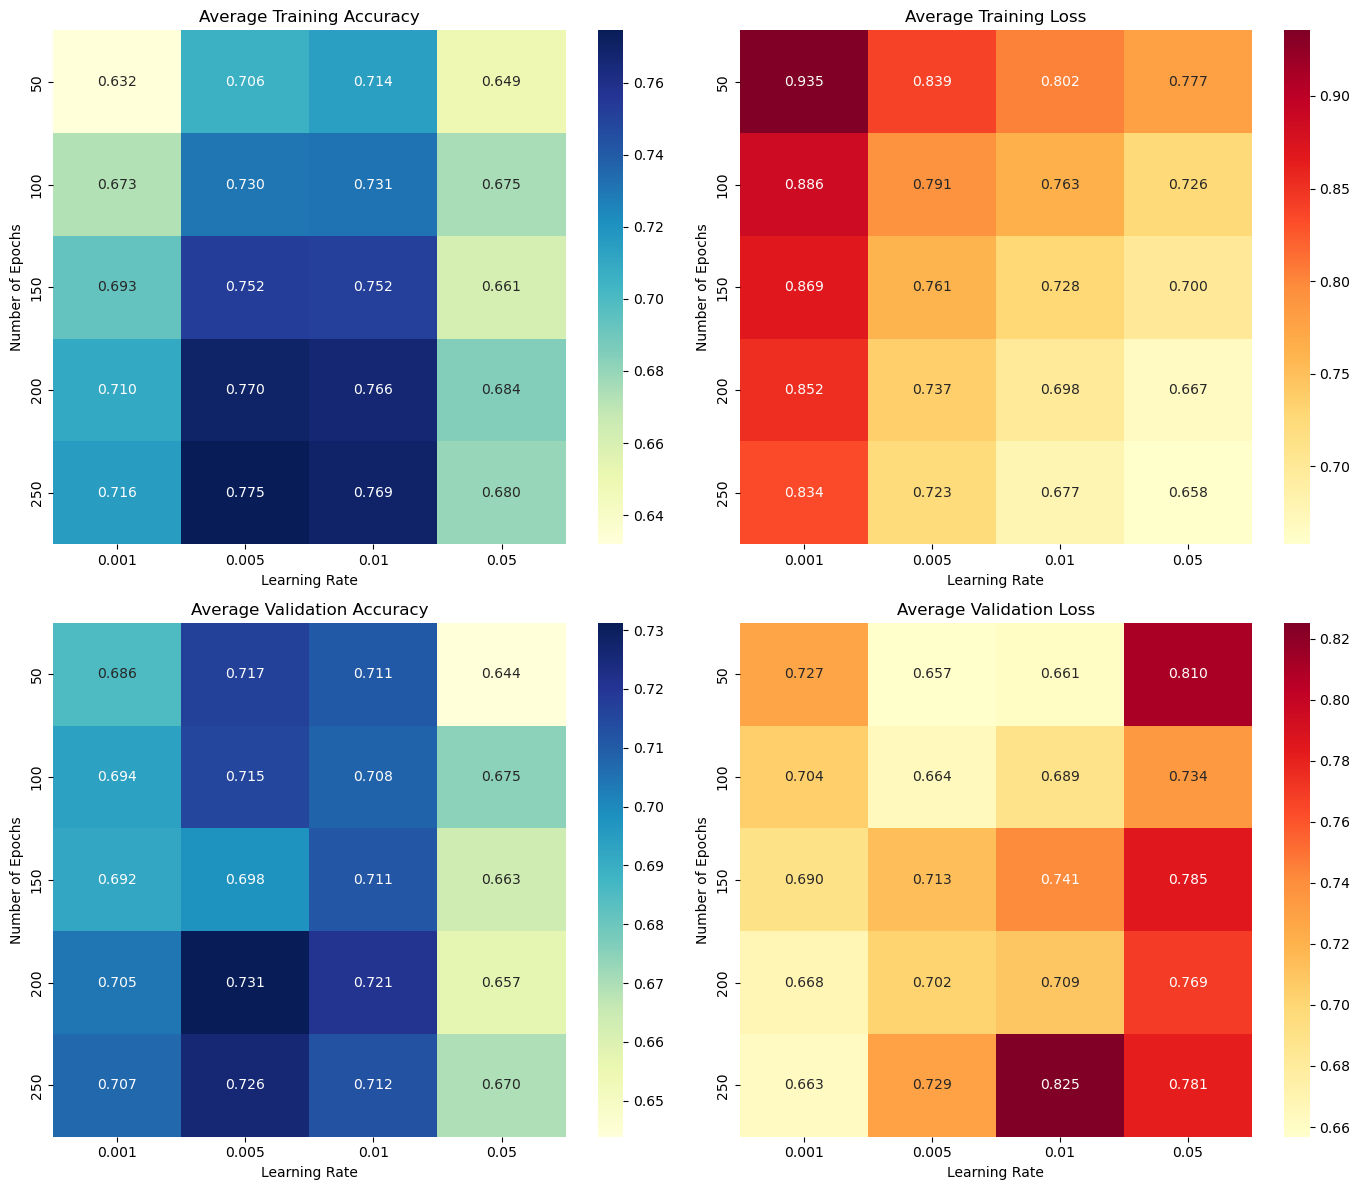

In [30]:
plot_grid_search_results(results, save=True, file_path="./images/GridSearch_HYBRID.png")

***
- Wasted too much time trying to improve the results that I ran out of time for to do my report properly, sorry ....
- I was even going to graph the gradients